# IIC-2433 Minería de Datos UC

- Versiones de librerías, python 3.8.10

- numpy 1.20.3
- sklearn 1.0.2
- nltk 3.7
- keras 2.9.0
- tensorflow 2.9.1


## Actividad en clase

Usando el algoritmo **VAE**, haga lo siguiente:

- Entrene el **VAE** sobre el dataset de mnist digits a 28x28 (el del jupyter 13). Use la partición de entrenamiento.
- Entrene una **nuSVC** a 0.1 sobre los primeros 5000 ejemplos de entrenamiento del dataset. Fíjese que la nuSVC es unidimensional, pero sus datos son 2D, por lo que va a tener que hacer un reshape.
- Evalúe el clasificador sobre los primeros 1000 ejemplos de testing.
- Genere un dígito con el VAE.
- Revise la escala del ejemplo generado con el VAE y hagalo consistente con la escala de los ejemplos usados para entrenar el clasificador. Va a tener que reescalar usanto la transformación min max. Hágala Ud. mismo.
- Usando el dígito sintético generado por el VAE y reescalado, páselo por el clasificador. ¿El resultado es correcto?
- Cuanto termine, me avisa para entregarle una **L (logrado)**.
- Recuerde que cada L es una décima más en la nota de la asignatura.
- Pueden trabajar de a dos.

***Tiene hasta el final de la clase.***


# Solución

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2024-05-25 23:15:40.681296: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
class Sampling(layers.Layer):

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [3]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs) 
x = layers.Conv2D(16, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 16)     4624        ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 784)          0           ['conv2d_1[0][0]']               
                                                                                            

2024-05-25 23:15:43.541552: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-12.0/lib64:/usr/local/cuda-11.8/lib64
2024-05-25 23:15:43.576534: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-05-25 23:15:43.577118: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebu

In [4]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 16, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 16))(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 784)               2352      
                                                                 
 reshape (Reshape)           (None, 7, 7, 16)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 32)       4640      
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 64)       18496     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        577 

In [5]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [6]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

In [7]:
x_train.shape

(60000, 28, 28)

In [8]:
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 17s 30ms/step - loss: 272.3409 - reconstruction_loss: 210.5092 - kl_loss: 2.7102
Epoch 2/30
547/547 [==============================] - 16s 29ms/step - loss: 177.1413 - reconstruction_loss: 169.9348 - kl_loss: 4.3813
Epoch 3/30
547/547 [==============================] - 16s 30ms/step - loss: 168.3144 - reconstruction_loss: 161.9209 - kl_loss: 4.8341
Epoch 4/30
547/547 [==============================] - 17s 31ms/step - loss: 163.5134 - reconstruction_loss: 157.4353 - kl_loss: 5.1477
Epoch 5/30
547/547 [==============================] - 17s 31ms/step - loss: 160.7042 - reconstruction_loss: 154.9619 - kl_loss: 5.3287
Epoch 6/30
547/547 [==============================] - 17s 31ms/step - loss: 159.2164 - reconstruction_loss: 153.5233 - kl_loss: 5.4293
Epoch 7/30
547/547 [==============================] - 17s 31ms/step - loss: 158.0317 - reconstruction_loss: 152.3881 - kl_loss: 5.5051
Epoch 8/30
547/547 [==============================] - 1

In [9]:
import random
import matplotlib.pyplot as plt

digit_size = 28
scale = 1.0

def generate_image(scale, digit_size):
    x_ = random.uniform(-scale, scale) # sampling de Uniforme[-1,+1]
    y_ = random.uniform(-scale, scale) # sampling de Uniforme[-1,+1]
    z_sample = np.array([[x_, y_]])
    x_decoded = vae.decoder.predict(z_sample) # pasamos por el decoder
    digit = x_decoded[0].reshape(digit_size, digit_size) # le hacemos un reshape al formato de la imagen (28x28)

    return digit

def plot_image(digit):
    plt.figure(figsize=(1,1))
    plt.axis('off')
    plt.imshow(digit, cmap="Greys_r")
    plt.show()

In [71]:
digit = generate_image(scale, digit_size)

1/1 [==============================] - 0s 28ms/step


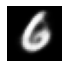

In [72]:
plot_image(digit)

In [55]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [56]:
x_train = x_train[:5000,:,:]
y_train = y_train[:5000]
x_test = x_test[:1000,:,:]
y_test = y_test[:1000]

In [57]:
x_train.shape

(5000, 28, 28)

In [58]:
x_train = x_train.reshape(5000,784)
x_test = x_test.reshape(1000,784)

In [59]:
from sklearn.svm import NuSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split


clf = make_pipeline(StandardScaler(), NuSVC(nu=0.1))
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.96      0.94        85
           1       0.99      0.98      0.99       126
           2       0.92      0.92      0.92       116
           3       0.93      0.92      0.92       107
           4       0.91      0.93      0.92       110
           5       0.94      0.90      0.92        87
           6       0.95      0.92      0.94        87
           7       0.85      0.93      0.89        99
           8       0.90      0.89      0.89        89
           9       0.92      0.87      0.90        94

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



1/1 [==============================] - 0s 17ms/step


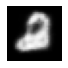

In [123]:
digit = generate_image(scale, digit_size)
plot_image(digit)

In [124]:
max = 255
min = 0

X_std = (digit - np.min(digit)) / (np.max(digit) - np.min(digit))
X_scaled = X_std * (max - min) + min

In [125]:
clf.predict(X_scaled.reshape(1,784))

array([2], dtype=uint8)